**Note:** After repeatedly trying through different media for three months, I have concluded that, sadly, I simply do not have the computational resources to completely process this project in its entirety. As a result, I'm including only my data wrangling, EDA and a baseline model in this notebook.

As always, here's the button you can click to toggle code:


In [23]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle code">
 </form>'
)

----------------------------------------------------------------------

## The Data

### 1. San Francisco Fire Department response data
The San Francisco Fire Department does one thing really well: capture data. The data for all the calls for service they receive, as well as their response to them, are captured really well [here](https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3/data). The data is at a call_id-response level. That means that, given that multiple units can respond to the same call, it captures one such such response in each row of its dataset.
Here's what the data looks like:

In [5]:
fire_dept_data <- read.csv('/home/ab/Downloads/Datasets for analysis/Fire Department Service Calls/Fire_Department_Calls_for_Service.csv',header = FALSE, nrows = 20,stringsAsFactors = FALSE)
head(fire_dept_data,5)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34
130350058,E38,13011886,Structure Fire,02/04/2013,02/03/2013,02/04/2013 03:58:46 AM,02/04/2013 03:59:48 AM,02/04/2013 04:00:00 AM,02/04/2013 04:01:51 AM,⋯,false,Fire,1,ENGINE,2,4,2,Marina,"(37.7979757626675, -122.428080525252)",130350058-E38
130350058,E41,13011886,Structure Fire,02/04/2013,02/03/2013,02/04/2013 03:58:46 AM,02/04/2013 03:59:48 AM,02/04/2013 04:00:00 AM,02/04/2013 04:02:46 AM,⋯,true,Fire,1,ENGINE,7,4,2,Marina,"(37.7979757626675, -122.428080525252)",130350058-E41
130350058,RC1,13011886,Structure Fire,02/04/2013,02/03/2013,02/04/2013 03:58:46 AM,02/04/2013 03:59:48 AM,02/04/2013 04:03:31 AM,02/04/2013 04:05:00 AM,⋯,true,Fire,1,RESCUE CAPTAIN,10,4,2,Marina,"(37.7979757626675, -122.428080525252)",130350058-RC1
130350058,RS1,13011886,Structure Fire,02/04/2013,02/03/2013,02/04/2013 03:58:46 AM,02/04/2013 03:59:48 AM,02/04/2013 04:00:00 AM,02/04/2013 04:01:39 AM,⋯,false,Fire,1,RESCUE SQUAD,11,4,2,Marina,"(37.7979757626675, -122.428080525252)",130350058-RS1
130350058,T02,13011886,Structure Fire,02/04/2013,02/03/2013,02/04/2013 03:58:46 AM,02/04/2013 03:59:48 AM,02/04/2013 04:00:00 AM,02/04/2013 04:02:09 AM,⋯,false,Fire,1,TRUCK,4,4,2,Marina,"(37.7979757626675, -122.428080525252)",130350058-T02


In [1]:
fire_dept <- read.csv('~/Downloads/Datasets for analysis/Fire Department Service Calls/fire_dept_ads.csv', header=T, stringsAsFactors = F)

### 2. Weather data
Additionally, I thought I might need to look at how the weather conditions would affect the fire department responses, directly (e.g. stormy weather or low visibility) or indirectly (e.g. rain causing a traffic jam causing delayed response).
My general recourse would be to head over to the NOAA, but they can't provide me hour-by-hour weather data including precipitation for this duration. Luckily enough, some kind soul has uploaded this data on Kaggle datasets [here](https://www.kaggle.com/selfishgene/historical-hourly-weather-data). It contains hourly weather description as well as temperature and wind speed data.

### 3. Fire Station Addresses
In order to calculate how far a given incident occurred from the nearest fire station, you would need the co-ordinates of each fire station. To get the co-ordinates of each fire station, you would first need at least the _address_ of each fire station. Sadly, that is not available as a friendly csv anywhere.
Until now.
Luckily, the fire department lists the addresses of each of the fire stations neatly [here](https://sf-fire.org/fire-station-locations). In an ideal world, you would use the google maps API to get the lat-long co-ordinates for these addresses, and be done with it. Sadly, ours is not that world. Long story short, I ended up using one of those [free online geocoding tools](http://www.mapdevelopers.com/batch_geocode_tool.php). The addresses for all the fire stations and their co-ordinates can be found in a neat csv in this repository.

## The cleaning
### 1. Time travel
Here is the order in which events generally happen:

1. Person in distress calls 911, informs them about the fire incident.
2. Emergency operator enters the call into the system
3. Dispatch assigns a unit to the call
4. Unit accepts the call and proceeds towards location
5. Unit reaches scene of the incident

That means that, in the data, if any of those things happen out of order, like a unit accepting a call before it is entered into the system, we can get rid of that row as an anomaly.

### 2. Fire Department.exe has stopped responding
There are cases in the data when the response time comes out to be 10,000 seconds or even more than that (that's close to three hours!) Whatever be the reason, these rows are outliers which will skew the response times, so we must remove them too.

## Exploratory Data Analysis
Here, I'm going to visualise how different factors may impact the response times. 
In each of these graphs:
'Entry Time' is the time taken for the call to be entered in the system
'Dispatch time' is the time taken after the call is entered till the time dispatch assigns it to a unit
'Response time' is the time taken by the unit to respond
'On Scene Time' is the time taken by the unit after it responds till it reaches the scene

### 1. Unit Type
How long do different types of units take to respond to an incident?

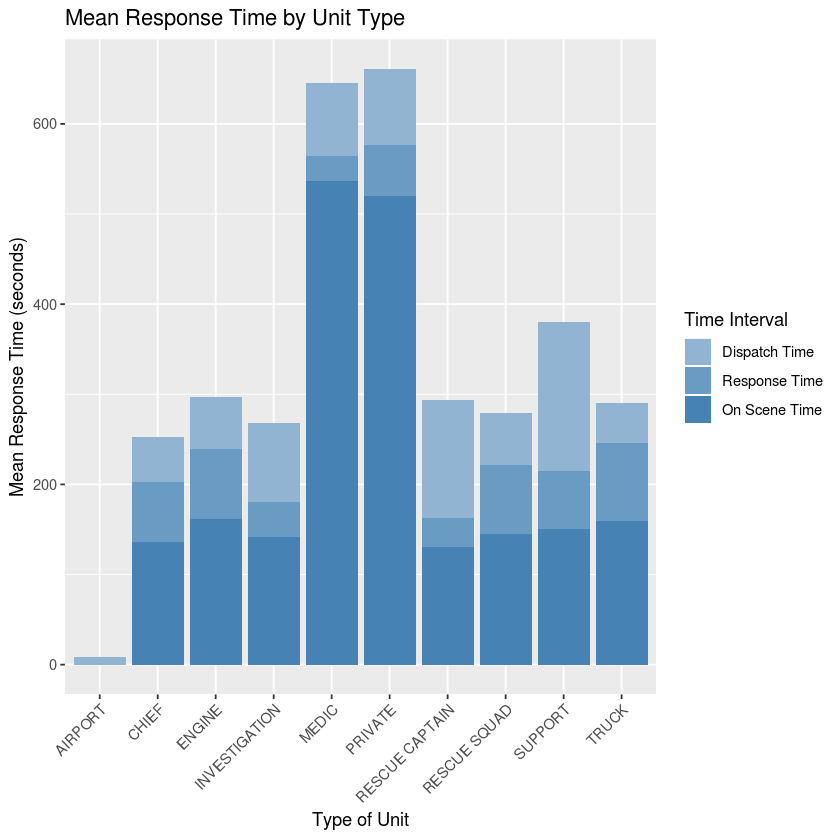

In [4]:
library(ggplot2)
dispatch_by_unit <- aggregate(dispatch_time ~ unit_type, fire_dept, mean)
response_by_unit <- aggregate(response_time ~ unit_type, fire_dept, mean)
on_scene_by_unit <- aggregate(on_scene_time ~ unit_type,fire_dept, mean)
response_by_unit <- merge(dispatch_by_unit, response_by_unit, by = 'unit_type')
response_by_unit <- merge(response_by_unit, on_scene_by_unit, by = 'unit_type')
library(reshape2)
response.m <- melt(response_by_unit, id = 'unit_type')
colnames(response.m) <- c('unit_type','time_interval','response_time')
unit_response_plot<-ggplot(data=response.m, aes(x=unit_type, y=response_time, fill = time_interval)) +
  geom_bar(stat="identity")+ theme(axis.text.x = element_text(angle = 45, hjust = 1))+
  scale_fill_manual(values = c('#90b4d2','#6a9bc3','#4682b4'),name="Time Interval", labels=c("Dispatch Time", "Response Time","On Scene Time"))+
  ggtitle("Mean Response Time by Unit Type")+xlab("Type of Unit")+ylab("Mean Response Time (seconds)")
unit_response_plot

### 2. Time of the day
Time of the day, I think, will affect the response time directly (shift timings, staffing etc) as well as indirectly (traffic conditions). Checking that out:

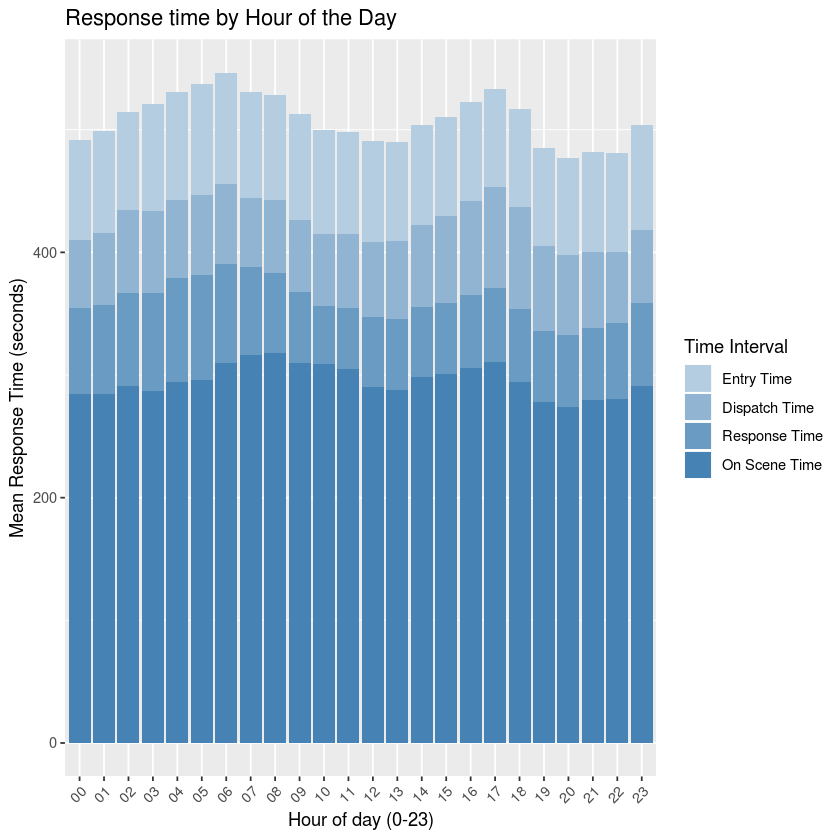

In [7]:
#Response Time by hour of the day
response_hour.1 <- aggregate(entry_time ~ strftime(recd_timestamp,'%H', tz = 'PDT'), fire_dept, mean)
colnames(response_hour.1) <- c('hour_of_day','entry_time')

response_hour.2 <- aggregate(dispatch_time ~ strftime(recd_timestamp,'%H', tz = 'PDT'), fire_dept, mean)
colnames(response_hour.2) <- c('hour_of_day','dispatch_time')

response_hour.3 <- aggregate(response_time ~ strftime(recd_timestamp,'%H', tz = 'PDT'), fire_dept, mean)
colnames(response_hour.3) <- c('hour_of_day','response_time')

response_hour.4 <- aggregate(on_scene_time ~ strftime(recd_timestamp,'%H', tz = 'PDT'), fire_dept, mean)
colnames(response_hour.4) <- c('hour_of_day','on_scene_time')

response_hour <- merge(response_hour.1, response_hour.2, by = 'hour_of_day')
response_hour <- merge(response_hour, response_hour.3, by = 'hour_of_day')
response_hour <- merge(response_hour, response_hour.4, by = 'hour_of_day')
response_hr.m <- melt(response_hour, id = 'hour_of_day')

response_by_hr_plot<-ggplot(data=response_hr.m, aes(x=hour_of_day, y=value, fill = variable)) +
  geom_bar(stat="identity")+ theme(axis.text.x = element_text(angle = 45, hjust = 1))+
  scale_fill_manual(values = c('#b5cde1','#90b4d2','#6a9bc3','#4682b4'),name="Time Interval", labels=c("Entry Time", "Dispatch Time", "Response Time","On Scene Time"))+
  ggtitle("Response time by Hour of the Day")+xlab("Hour of day (0-23)")+ylab("Mean Response Time (seconds)")

response_by_hr_plot

The mean response time expectedly peaks during rush hour traffic, but is still remarkably consistent throughout the day.

### Call type
Depending on situation of the incident, calls are classified into different types, like 'Elevator rescue' or 'Industrial accident'. 

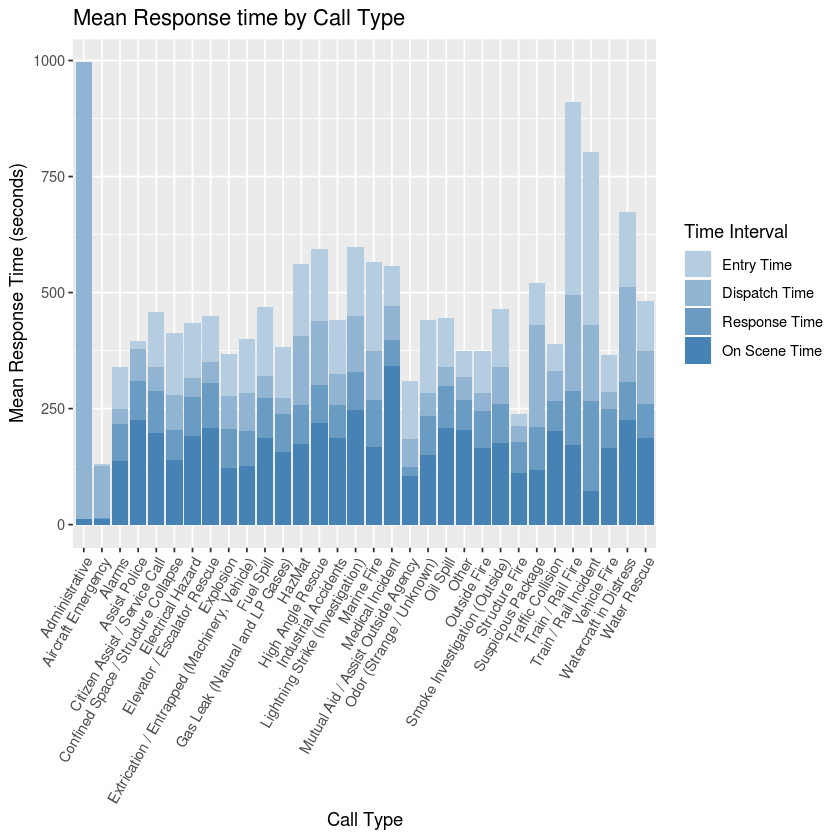

In [9]:
response_call_type.1 <- aggregate(entry_time ~ call_type, fire_dept, mean)
colnames(response_call_type.1) <- c('call_type','entry_time')

response_call_type.2 <- aggregate(dispatch_time ~ call_type, fire_dept, mean)
colnames(response_call_type.2) <- c('call_type','dispatch_time')

response_call_type.3 <- aggregate(response_time ~ call_type, fire_dept, mean)
colnames(response_call_type.3) <- c('call_type','response_time')

response_call_type.4 <- aggregate(on_scene_time ~ call_type, fire_dept, mean)
colnames(response_call_type.4) <- c('call_type','on_scene_time')

response_call_type <- merge(response_call_type.1, response_call_type.2, by = 'call_type')
response_call_type <- merge(response_call_type, response_call_type.3, by = 'call_type')
response_call_type <- merge(response_call_type, response_call_type.4, by = 'call_type')
response_call_type.m <- melt(response_call_type, id= 'call_type')

response_by_call_type_plot<-ggplot(data=response_call_type.m, aes(x=call_type, y=value, fill = variable)) +
  geom_bar(stat="identity")+ theme(axis.text.x = element_text(angle = 60, hjust = 1))+
  scale_fill_manual(values = c('#b5cde1','#90b4d2','#6a9bc3','#4682b4'),name="Time Interval", labels=c("Entry Time","Dispatch Time", "Response Time","On Scene Time"))+
  ggtitle("Mean Response time by Call Type")+xlab("Call Type")+ylab("Mean Response Time (seconds)")

response_by_call_type_plot

### Number of Alarms
Fire department calls are given priority according to the 'alarms' associated with the incident. A multiple-alarm fire is one that is severe and difficult to contain.
Obviously, fires with more alarms will be treated with more urgency, but they may also need more time for co-ordination.

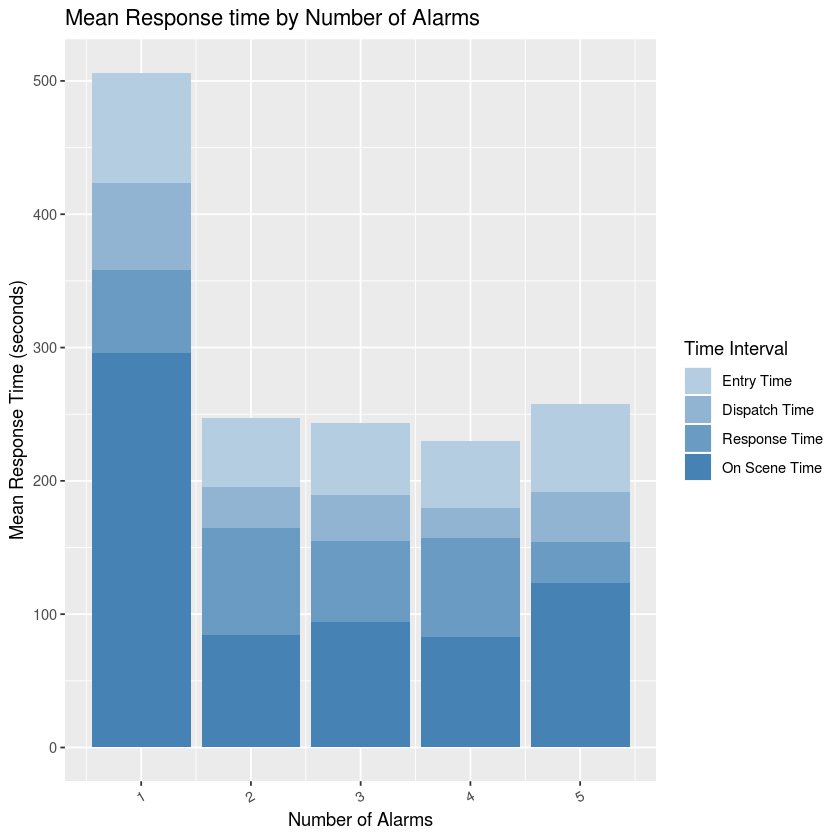

In [13]:
#Response time by number of alarms
response_alarm.1 <- aggregate(entry_time ~ number_of_alarms, fire_dept, mean)
colnames(response_alarm.1) <- c('number_of_alarms','entry_time')

response_alarm.2 <- aggregate(dispatch_time ~ number_of_alarms, fire_dept, mean)
colnames(response_alarm.2) <- c('number_of_alarms','dispatch_time')

response_alarm.3 <- aggregate(response_time ~ number_of_alarms, fire_dept, mean)
colnames(response_alarm.3) <- c('number_of_alarms','response_time')

response_alarm.4 <- aggregate(on_scene_time ~ number_of_alarms, fire_dept, mean)
colnames(response_alarm.4) <- c('number_of_alarms','on_scene_time')

response_alarm <- merge(response_alarm.1, response_alarm.2, by = 'number_of_alarms')
response_alarm <- merge(response_alarm, response_alarm.3, by = 'number_of_alarms')
response_alarm <- merge(response_alarm, response_alarm.4, by = 'number_of_alarms')
response_alarm.m <- melt(response_alarm, id.vars = 'number_of_alarms')

response_by_number_of_alarms_plot<-ggplot(data=response_alarm.m, aes(x=number_of_alarms, y=value, fill = variable)) +
  geom_bar(stat="identity")+ theme(axis.text.x = element_text(angle = 30, hjust = 1))+
  scale_fill_manual(values = c('#b5cde1','#90b4d2','#6a9bc3','#4682b4'),name="Time Interval", labels=c("Entry Time","Dispatch Time", "Response Time","On Scene Time"))+
  ggtitle("Mean Response time by Number of Alarms")+xlab("Number of Alarms")+ylab("Mean Response Time (seconds)")

response_by_number_of_alarms_plot

As expected, more the number of alarms, faster the response time. It is also possible that a 5-alarm fire may be further out from the city, resulting a longer response time.

### Weather
I think this one is worth looking at: How do fire dept. response times differ for different weather conditions? To do this, I got the hourly San Francisco weather data, and merged it with each call to get what the weather was at the time of each call. Here's how the mean response time varies with the weather description of the hour:

Warning message in merge.data.frame(fire_dept, sf_weather, by.x = c("call_date", :
“column names ‘datetime.x’, ‘weather_description.x’, ‘temperature.x’, ‘wind_speed.x’, ‘datetime.y’, ‘weather_description.y’, ‘temperature.y’, ‘wind_speed.y’ are duplicated in the result”Using weather_description as id variables


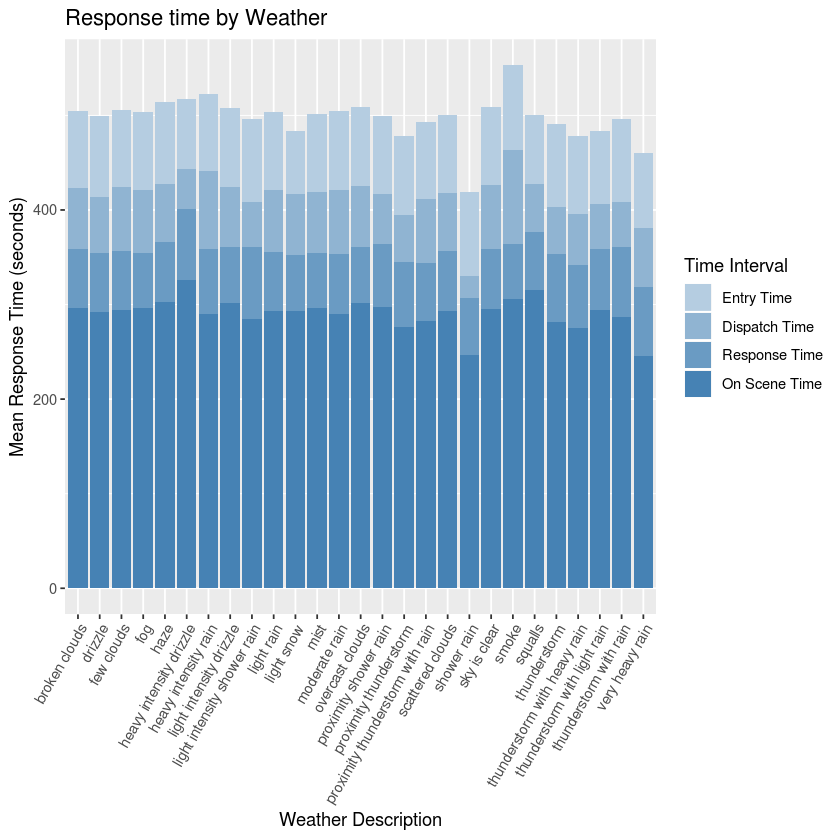

In [19]:
#Load the weather data
sf_weather_desc <- read.csv('/home/ab/Downloads/Datasets for analysis/Fire Department Service Calls/sf_weather_description.csv', stringsAsFactors = FALSE)
sf_temp <- read.csv('/home/ab/Downloads/Datasets for analysis/Fire Department Service Calls/sf_temperature.csv')
sf_wind_speed <- read.csv('/home/ab/Downloads/Datasets for analysis/Fire Department Service Calls/sf_wind_speed.csv')
sf_weather_desc$datetime <- as.POSIXct(sf_weather_desc$datetime, tz = 'PDT')
colnames(sf_weather_desc) <- c('datetime','weather_description')
sf_temp$datetime <- as.POSIXct(sf_temp$datetime, tz = 'PDT')
colnames(sf_temp) <- c('datetime','temperature')
sf_wind_speed$datetime <- as.POSIXct(sf_wind_speed$datetime, tz = 'PDT')
colnames(sf_wind_speed) <- c('datetime','wind_speed')

sf_weather <- merge(sf_weather_desc, sf_temp, by = 'datetime')
sf_weather <- merge(sf_weather, sf_wind_speed, by = 'datetime')                    

#Need to make it in a format with date and hour of day separate
sf_weather$date <- strftime(sf_weather$datetime, '%F')
sf_weather$hour_of_day <- strftime(sf_weather$datetime, '%H')
sf_weather <- sf_weather[sf_weather$date >= '2013-06-01' & sf_weather$date <= '2017-10-27',]
#Check for NAs
#sum(is.na(sf_weather$weather_description))  #0
#sum(is.na(sf_weather$temperature))  #0
#sum(is.na(sf_weather$wind_speed))   #1
sf_weather$wind_speed[is.na(sf_weather$wind_speed)] <- median(na.omit(sf_weather$wind_speed))


fire_dept$hour_of_day <- strftime(fire_dept$recd_timestamp,'%H')
fire_dept <- merge(fire_dept, sf_weather, by.x = c('call_date','hour_of_day'), by.y = c('date','hour_of_day'))

#How does response time vary by weather?
#unique(fire_dept$weather_description)

response_weather.1 <- aggregate(entry_time ~ weather_description, fire_dept, mean)
colnames(response_weather.1) <- c('weather_description','entry_time')

response_weather.2 <- aggregate(dispatch_time ~ weather_description, fire_dept, mean)
colnames(response_weather.2) <- c('weather_description','dispatch_time')

response_weather.3 <- aggregate(response_time ~ weather_description, fire_dept, mean)
colnames(response_weather.3) <- c('weather_description','response_time')

response_weather.4 <- aggregate(on_scene_time ~ weather_description, fire_dept, mean)
colnames(response_weather.4) <- c('weather_description','on_scene_time')

response_weather <- merge(response_weather.1, response_weather.2, by = 'weather_description')
response_weather <- merge(response_weather, response_weather.3, by = 'weather_description')
response_weather <- merge(response_weather, response_weather.4, by = 'weather_description')
response_weather.m <- melt(response_weather)

response_by_weather_plot<-ggplot(data=response_weather.m, aes(x=weather_description, y=value, fill = variable)) +
  geom_bar(stat="identity")+ theme(axis.text.x = element_text(angle = 60, hjust = 1))+
  scale_fill_manual(values = c('#b5cde1','#90b4d2','#6a9bc3','#4682b4'),name="Time Interval", labels=c("Entry Time", "Dispatch Time", "Response Time","On Scene Time"))+
  ggtitle("Response time by Weather")+xlab("Weather Description")+ylab("Mean Response Time (seconds)")

response_by_weather_plot

Rather expectedly, smoke will cause delays in fire responses.

## Baseline Model
Now for my basic, baseline, base model.
I have tried everything with this: I once ran the code to train a model for twenty-four hours straight, and my laptop was _still_ hung. I tried using an Amazon EC2 instance (and exhausted my Free Tier limit). I took a subset of only three years, then two, then one-and-a-half. Because this data is big, and because the one-hot encoding will create some 200+ columns, I simply can't process it with the infra I have.
Anyway, I'm gonna put the code for it here, commented out because I have to work at some point in the next two days.

In [ ]:
# fire_dept$station_area <- as.factor(fire_dept$station_area)
# fire_dept$hour_of_day <- as.factor(fire_dept$hour_of_day)
# fire_dept$call_type <- as.factor(fire_dept$call_type)
# fire_dept$zipcode <- as.factor(fire_dept$zipcode)
# fire_dept$original_priority <- as.factor(fire_dept$original_priority)
# fire_dept$weather_description <- as.factor(fire_dept$weather_description)
# fire_dept$battalion <- as.factor(fire_dept$battalion)
# fire_dept$unit_type <- as.factor(fire_dept$unit_type)
# fire_dept$neighbourhood_dist <- as.factor(fire_dept$neighbourhood_dist)
# fire_dept$als_unit <- as.factor(fire_dept$als_unit)
# 
# 
# #Divide into train and test
# sample_size <- floor(0.6 * nrow(fire_dept))
# set.seed(2014)
# train_index <- sample(seq_len(nrow(fire_dept)), size = sample_size)
# fire_train <- fire_dept[train_index,]
# remain40 <- fire_dept[-train_index,]
# test_valid_index <- sample(seq_len(nrow(remain40)), 0.5*nrow(remain40))
# fire_validn <- remain40[test_valid_index,]
# fire_test <- remain40[-test_valid_index,]

First, let's establish what the distribution of the response times looks like.

In [21]:
sprintf('The mean response time is: %f',mean(fire_dept$total_response_time))
sprintf('The standard deviation of response time is: %f',sd(fire_dept$total_response_time))

[1] "The mean response time is: 505.901925"

[1] "The standard deviation of response time is: 399.392310"

First, let me establish a baseline model, the mean itself. If a prediction of the mean does better than my model, then, well, the model sucks.
The RMSE of the mean would be none other than the standard deviation, so:

In [22]:
sprintf('The RMSE of mean baseline prediction of response time is: %f',sd(fire_dept$total_response_time))

[1] "The RMSE of mean baseline prediction of response time is: 399.392310"

And the winning baseline model is... < Toggle seeing code above >

In [ ]:
# library(rpart)
# dtree_63 <- rpart(total_response_time ~ station_area+hour_of_day+call_type+battalion+als_unit+
#                    original_priority+weather_description+temperature+final_priority+unit_type+
#                    wind_speed+distance_from_station+number_of_alarms+zero_time_flag, fire_train_3)
# 
# fire_validn_3$predicted_response_time <- predict(dtree_63,fire_validn_3)
# fire_validn_err3 <- rmse(fire_validn_3$total_response_time, fire_validn_3$predicted_response_time)
# #RMSE is now 314.56. Cool.

This basic decision tree model gives an RMSE of 314.56, which is a 21.25% reduction in RMSE over the baseline. That's pretty good for a baseline model.
Unfortunately, this is where we stop for now, until I get a better laptop.
If you know a supercomputer, put me in touch....